*In this notebook I test the performances of the FastDensityPeaks algorithm within 3 real datasets:*

1. Credit Approval (653 instances, 15 attributes, mixed values)
2. Banknote (1372 instances, 4 attributes, real)
3. Pendigits (10992 instances, 15 attributes, integers)

In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle, islice

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, davies_bouldin_score, silhouette_score, calinski_harabasz_score

from sklearn import cluster

from datasets.datasets import load
from fastdensitypeaks import FastDensityPeaks

### Decision graphs

In the next section I show the decision graphs (rho/delta) obtained with FastDensity Peak. Notice that the autossign method that I included in the algorithm seems to work very well also with real datasets. Actually, for Pendigits only 4 centroids (instead of 10) are retrieved. In any case, it is still possible and easy to retrieve the correct centroids with manual assignation

CREDIT APPROVAL


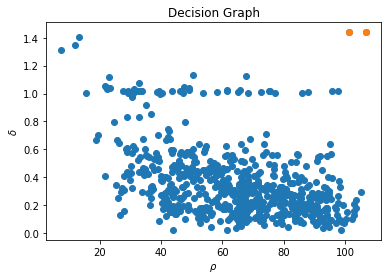

BANKNOTE


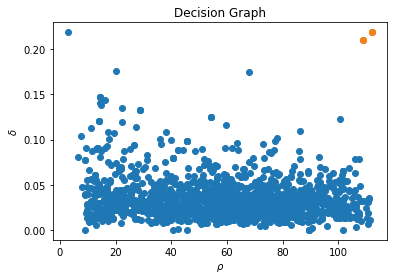

PENDIGITS


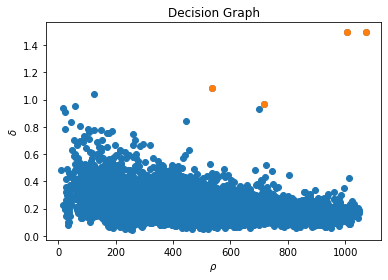

CPU times: user 4.11 s, sys: 1.24 s, total: 5.34 s
Wall time: 3.66 s


In [2]:
%%time
datasets = {1:'Credit Approval', 2:'Banknote', 3:'Pendigits'}
for d in datasets:
    print(datasets[d].upper())
    X, y = load(d)
    X = MinMaxScaler().fit_transform(X)
    fdp = FastDensityPeaks(autoassign=True)
    fdp.fit(X)

### Plots

In the next cell I'll retrieve the clusters with FastDensityPeakss and other well-known clustering algorithms, I'll plot the clusters in a way that they are comparable with each other

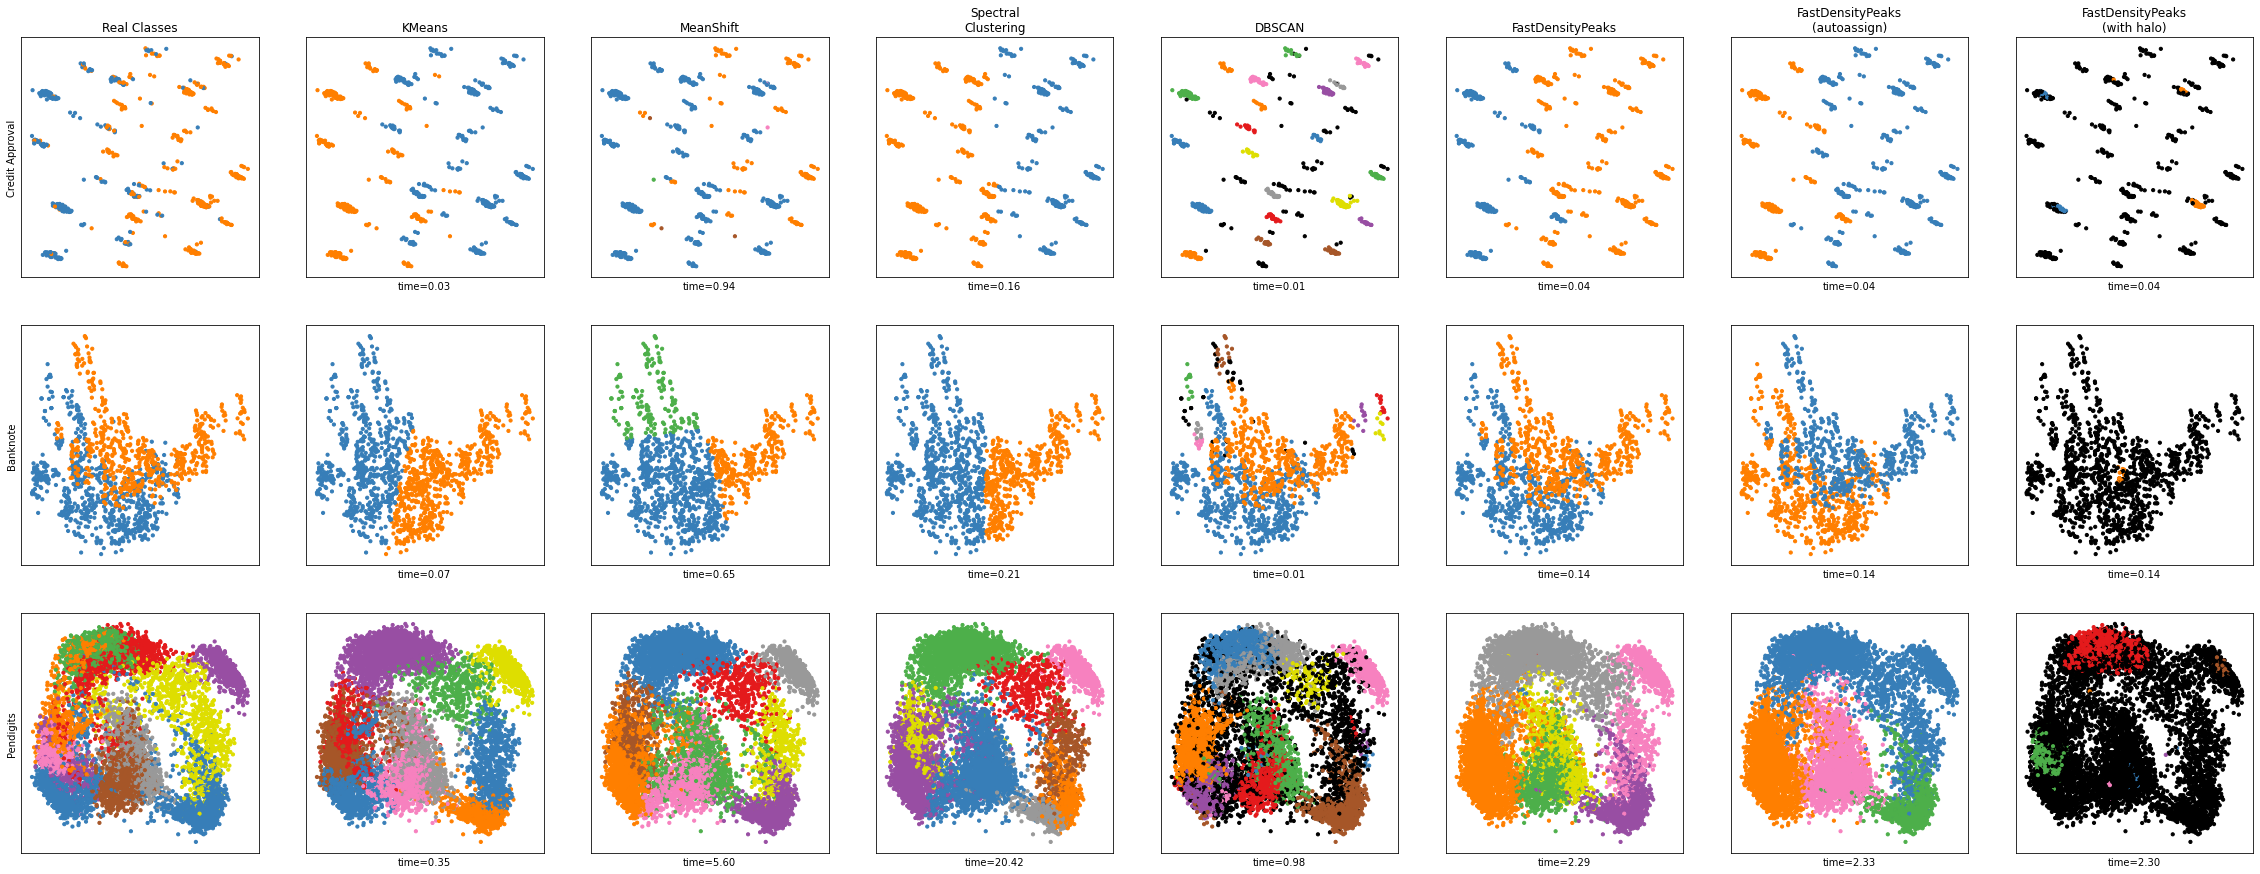

In [3]:
datasets = {1:'Credit Approval', 2:'Banknote', 3:'Pendigits'}
n_clusters = [2,2,10] # ground trouth n_clusters, serves for k-means ecc.
eps = [.8, .1, .3] #eps for dbscan
quantile = [.1,.1, 0.05]
graph_decisions = [(80,1.2), (80,0.15), (15,0.84)] # for fdp, retrieved from the plots above

fig, ax = plt.subplots(len(datasets), 8, figsize=(40,15))

for d in datasets:

    X, y = load(d)
    X = MinMaxScaler().fit_transform(X) # normalize dataset for easier parameter selection

    """Create cluster objects"""
    #Mean Shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=quantile[d-1])
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    #Kmeans
    kmeans = cluster.KMeans(n_clusters=n_clusters[d-1])
    #Spectral Clustering
    spectral = cluster.SpectralClustering(n_clusters=n_clusters[d-1], eigen_solver='arpack', affinity="rbf")
    #Dbscan
    dbscan = cluster.DBSCAN(eps=eps[d-1], min_samples=10)
    # FastDensityPeaks
    fdp = FastDensityPeaks(verbose=False, autoassign=False)
    # FastDensityPeaks with autoassign
    fdp_auto = FastDensityPeaks(verbose=False, autoassign=True)

    clustering_algorithms = (('Real Classes',None),('KMeans', kmeans),('MeanShift', ms),
                             ('Spectral\nClustering', spectral),('DBSCAN', dbscan),
                             ('FastDensityPeaks', fdp),('FastDensityPeaks\n(autoassign)', fdp_auto),
                             ('FastDensityPeaks\n(with halo)', fdp))
    
    
    """Fit the algorithms and get the results"""
    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        
        if name != 'Real Classes':
            # Avoid annoying spectral clustering warning while fitting the algorithms
            with warnings.catch_warnings(): 
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)
                t0 = time.time()
                algorithm.fit(X)
                if name == 'FastDensityPeaks' or name == 'FastDensityPeaks\n(with halo)':
                    algorithm.decision_graph(*graph_decisions[d-1])
                t1 = time.time()
    
        # Get the labels
        if name == 'Real Classes':
            y_pred = y
        elif name == 'FastDensityPeaks\n(with halo)':
            y_pred = algorithm.get_halo()
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
            

        """Plot the results"""
        # Color palette (to display consistent plots)
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
        colors = np.append(colors, ["#000000"])# add black color for outliers (if any)
        
        
        pca = PCA(2) # Embed in two dimensions with PCA for better visualization
        X_pca = pca.fit_transform(X)
        
        ax[d-1, i_algorithm].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[y_pred])
        ax[d-1, i_algorithm].set_xticks(())
        ax[d-1, i_algorithm].set_yticks(())
        if d == 1:
            ax[d-1, i_algorithm].set_title(name)
        if i_algorithm == 0:
            ax[d-1, i_algorithm].set_ylabel(datasets[d])
        else:
            ax[d-1, i_algorithm].set_xlabel('time={:.2f}'.format(t1-t0))

plt.savefig('results/real_datasets.png',bbox_inches = 'tight',pad_inches = 0.2)
plt.show()

### Evaluation metrics

In the next cell I'll use some usual evaluation metrics to compare the results obtained with the clustering algorithms considered above

In [4]:
def adjust_labels(y_pred, y_true):
    """
    Simple function that switch the labels so that
    correspond to the ground trouth, using an heuristic
    based on the labels' sizes similarities. Works
    mainly for binary classes
    """
    y_adjusted = y_pred.copy()
    uniques_true, counts_true = np.unique(y_true, return_counts=True)
    uniques_pred, counts_pred = np.unique(y_adjusted, return_counts=True)
    for cl, counts in zip(uniques_true, counts_true):
        most_plausible_class = np.argmax(counts_pred - counts)
        y_adjusted[np.where(y_pred==most_plausible_class)] = cl
        counts_pred[most_plausible_class] = 0
    return y_adjusted

In [5]:
datasets = {1:'Credit Approval', 2:'Banknote', 3:'Pendigits'}
n_clusters = [2,2,10] # ground trouth n_clusters, serves for k-means ecc.
eps = [.8, .1, .3] #eps for dbscan
quantile = [.1,.1, 0.05]
graph_decisions = [(80,1.2), (80,0.15), (15,0.84)] # for fdp, retrieved from the plots above

# Define the evauluation metrics
metrics = {'Accuracy':accuracy_score, 'Davies Bouldin': davies_bouldin_score,\
           'Silhouette': silhouette_score, 'Calinksi': calinski_harabasz_score, 'Time':None}
# Prepare the dataframe
idx1 = np.repeat(list(datasets.values()), len(metrics))
idx2 = np.tile(list(metrics.keys()), len(datasets))
df = pd.DataFrame(columns=['Real Classes','KMeans','MeanShift','SpectralClustering','DBSCAN','FastDensityPeaks',
                           'FastDensityPeaks(autoassign)','FastDensityPeaks(with halo)'], index=[idx1, idx2])

for d in datasets:

    X, y = load(d)
    X = MinMaxScaler().fit_transform(X) # normalize dataset for easier parameter selection

    """Create cluster objects"""
    #Mean Shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=quantile[d-1])
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    #Kmeans
    kmeans = cluster.KMeans(n_clusters=n_clusters[d-1])
    #Spectral Clustering
    spectral = cluster.SpectralClustering(n_clusters=n_clusters[d-1], eigen_solver='arpack', affinity="rbf")
    #Dbscan
    dbscan = cluster.DBSCAN(eps=eps[d-1], min_samples=10)
    # FastDensityPeaks
    fdp = FastDensityPeaks(verbose=False, autoassign=False)
    # FastDensityPeaks with autoassign
    fdp_auto = FastDensityPeaks(verbose=False, autoassign=True)

    clustering_algorithms = (('Real Classes',None),('KMeans', kmeans),('MeanShift', ms),
                             ('SpectralClustering', spectral),('DBSCAN', dbscan),
                             ('FastDensityPeaks', fdp),('FastDensityPeaks(autoassign)', fdp_auto),
                             ('FastDensityPeaks(with halo)', fdp))
    
    
    """Fit the algorithms"""
    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        
        if name != 'Real Classes':
            # Avoid annoying spectral clustering warning while fitting the algorithms
            with warnings.catch_warnings(): 
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)
                t0 = time.time()
                algorithm.fit(X)
                if name == 'FastDensityPeaks' or name == 'FastDensityPeaks\n(with halo)':
                    algorithm.decision_graph(*graph_decisions[d-1])
                t1 = time.time()
    
        # Get the labels
        if name == 'Real Classes':
            y_pred = y
        elif name == 'FastDensityPeaks(with halo)':
            y_pred = algorithm.get_halo()
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)   
        
        """Save the evaluation metrics"""
        no_noise_indexes = np.where(y_pred!=-1) # Retrieve the indexex without noise (for Dbscan and fdp)
        for m in metrics: 
            
            if m=='Accuracy': #adjust the labels for have an accuracy score that makes sense
                y_adj = adjust_labels(y_pred, y) 
                if accuracy_score(y, y_adj) > accuracy_score(y, y_pred):
                    df.loc[datasets[d], m][name] = accuracy_score(y, y_adj)
                else:
                    df.loc[datasets[d], m][name] = accuracy_score(y, y_pred)        
            elif m=='Time':
                if name == 'Real Classes':
                    df.loc[datasets[d], m][name] = 0
                else:
                    df.loc[datasets[d], m][name] = t1-t0            
            else:
                if np.unique(y_pred).size == 1: # Case in which no clusters are retrieved
                    df.loc[datasets[d], m][name] = None
                else:
                    df.loc[datasets[d], m][name] = metrics[m](X[no_noise_indexes], y_pred[no_noise_indexes])

# Save the dataframe and display
df = df.astype('float').round(3)
df.to_csv('results/real_datasets_metrics.csv')
df

Real Classes    KMeans  MeanShift  \
Credit Approval Accuracy               1.000     0.729      0.560   
                Davies Bouldin         2.534     1.958      1.449   
                Silhouette             0.130     0.196      0.111   
                Calinksi              96.266   160.779     28.525   
                Time                   0.000     0.039      0.927   
Banknote        Accuracy               1.000     0.424      0.633   
                Davies Bouldin         1.816     1.191      0.998   
                Silhouette             0.210     0.331      0.313   
                Calinksi             345.565   822.071    696.874   
                Time                   0.000     0.058      0.673   
Pendigits       Accuracy               1.000     0.126      0.056   
                Davies Bouldin         2.321     1.269      1.126   
                Silhouette             0.181     0.319      0.296   
                Calinksi            1404.466  2826.148   1743.145   
                Time                   0.000     0.349      5.511   

                                SpectralClustering   DBSCAN  FastDensityPeaks  \
Credit Approval Accuracy                     0.790    0.090             0.796   
                Davies Bouldin               1.986    1.009             2.026   
                Silhouette                   0.193    0.417             0.174   
                Calinksi                   156.718  110.847           140.313   
                Time                         0.061    0.014             0.031   
Banknote        Accuracy                     0.624    0.896             0.977   
                Davies Bouldin               1.171    0.818             1.781   
                Silhouette                   0.322    0.048             0.214   
                Calinksi                   778.792  107.437           358.665   
                Time                         0.229    0.014             0.141   
Pendigits       Accuracy                     0.074    0.083             0.083   
                Davies Bouldin               1.145    1.025             1.048   
                Silhouette                   0.320    0.160             0.250   
                Calinksi                  2674.443  951.302          1555.922   
                Time                        19.992    0.976             2.305   

                                FastDensityPeaks(autoassign)  \
Credit Approval Accuracy                               0.204   
                Davies Bouldin                         2.026   
                Silhouette                             0.174   
                Calinksi                             140.313   
                Time                                   0.033   
Banknote        Accuracy                               0.977   
                Davies Bouldin                         1.781   
                Silhouette                             0.214   
                Calinksi                             358.665   
                Time                                   0.137   
Pendigits       Accuracy                               0.073   
                Davies Bouldin                         1.564   
                Silhouette                             0.229   
                Calinksi                            2541.264   
                Time                                   2.374   

                                FastDensityPeaks(with halo)  
Credit Approval Accuracy                              0.152  
                Davies Bouldin                        0.884  
                Silhouette                            0.498  
                Calinksi                            127.550  
                Time                                  0.032  
Banknote        Accuracy                              0.008  
                Davies Bouldin                        0.121  
                Silhouette                            0.749  
                Calinksi                       